# Experiment 2: Problem as Binary classification
Use `BCE loss` for classification

Imports

In [1]:
import torch
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

import numpy as np
import random
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

Set seed for reproducibility

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

Metric calculation function

In [3]:
def get_precision_recall_f1_accuracy(preds, actual):
    tp = torch.logical_and(preds, actual).sum().item()
    tn = torch.logical_and(torch.logical_not(preds), torch.logical_not(actual)).sum().item()
    fp = torch.logical_and(preds, torch.logical_not(actual)).sum().item()
    fn = torch.logical_and(torch.logical_not(preds), actual).sum().item()
    
    precision = tp / (tp + fp + 0.00001)
    recall = tp / (tp + fn + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    accuracy = (tp + tn)/ (tp + tn + fp + fn + 0.00001)
    
    return precision, recall, f1, accuracy

Define Dataset and Dataloader

In [4]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, indices, transform=None):
        self.image_paths = glob(os.path.join(root_dir, "*", "*"))
        self.indices = indices
        self.transform = transform
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, index):
        idx = self.indices[index]
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        disease = os.path.basename(os.path.dirname(image_path))
        
        return self.transform(image), torch.tensor(1 if disease == 'monkeypox' else 0)

In [5]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop((224, 224), (0.7, 1)),
    transforms.RandomRotation(15)
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Resize((224, 224)),
])

In [6]:
size = len(glob(os.path.join('data/combined', "*", "*")))
train_size = int(size * 0.8)
indices = list(range(size))
random.shuffle(indices)
train_set = CustomDataset('data/combined', indices[:train_size], train_transform)
val_set = CustomDataset('data/combined', indices[train_size:], val_transform)

In [7]:
train_loader = DataLoader(train_set, 8, shuffle=True)
val_loader = DataLoader(val_set, 8, shuffle=False)

Check available device for inference

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Prepare for training

In [14]:
model = resnet50()
# /home/dilith/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
model.load_state_dict(torch.load("/home/dilith/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth"))
model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 1),
    torch.nn.Sigmoid()
)
# model.load_state_dict(torch.load("/home/dilith/Projects/monkeypox/models/best_model.pt"))
model = model.to(device)

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.BCELoss()

In [16]:
metrics = {phase: {metric: [] for metric in ['loss', 'acc', 'prec', 'rec', 'f1']} for phase in ['train', 'val']}

Training

In [17]:
best_loss = 1
for ep in range(130):
    print(f"------ Epoch {ep} ------")
    ep_metrics = {phase: {metric: 0 for metric in ['loss', 'acc', 'prec', 'rec', 'f1']} for phase in ['train', 'val']}
    for image, label in train_loader:
        image = image.to(device)
        label = label.to(device)
        
        out = model(image).squeeze()
        loss = criterion(out, label.float())
        
        bsz = image.size(0)
        ep_metrics['train']['loss'] += loss.item() * bsz
        prec, rec, f1, acc = get_precision_recall_f1_accuracy(out > 0.3, label.bool())
        ep_metrics['train']['prec'] += prec * bsz
        ep_metrics['train']['rec'] += rec * bsz
        ep_metrics['train']['f1'] += f1 * bsz
        ep_metrics['train']['acc'] += acc * bsz
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        for image, label in val_loader:
            image = image.to(device)
            label = label.to(device)
            
            out = model(image).squeeze()
            loss = criterion(out, label.float())
            
            bsz = image.size(0)
            ep_metrics['val']['loss'] += loss.item() * bsz
            prec, rec, f1, acc = get_precision_recall_f1_accuracy(out > 0.3, label.bool())
            ep_metrics['val']['prec'] += prec * bsz
            ep_metrics['val']['rec'] += rec * bsz
            ep_metrics['val']['f1'] += f1 * bsz
            ep_metrics['val']['acc'] += acc * bsz
    
    for phase in ep_metrics:
        for metric in ep_metrics[phase]:
            ep_metrics[phase][metric] /= len(train_set if phase == 'train' else val_set)
            metrics[phase][metric].append(ep_metrics[phase][metric])
    
    if ep_metrics['val']['loss'] < best_loss:
        best_loss = ep_metrics['val']['loss']
        torch.save(model.state_dict(), f'models/model_bin_{ep}.pt')
        print("Saved Model")
    
    for phase in ep_metrics:
        print("=>", phase)
        print(ep_metrics[phase])

------ Epoch 0 ------
=> train
{'loss': 0.8641279536312317, 'acc': 0.5732528846648187, 'prec': 0.28732587731927, 'rec': 0.4595244262579448, 'f1': 0.30933019851964094}
=> val
{'loss': 0.5233464489812436, 'acc': 0.653260052990152, 'prec': 0.33985361172211415, 'rec': 0.3966643565627012, 'f1': 0.33672463055347435}
------ Epoch 1 ------
=> train
{'loss': 0.5611463201681082, 'acc': 0.6164710965722365, 'prec': 0.35928301103469895, 'rec': 0.5282383934795336, 'f1': 0.3877952020637359}
=> val
{'loss': 0.5270505620085675, 'acc': 0.630433994566203, 'prec': 0.34115833266071977, 'rec': 0.5257940037425092, 'f1': 0.3860479762071301}
------ Epoch 2 ------
=> train
{'loss': 0.5502693724068457, 'acc': 0.6140247826961793, 'prec': 0.3708915202413291, 'rec': 0.5681998893577527, 'f1': 0.41319068898988204}
=> val
{'loss': 0.5331514970115994, 'acc': 0.611955756794435, 'prec': 0.3294191854874213, 'rec': 0.5066636449016085, 'f1': 0.3666277627396921}
------ Epoch 3 ------
=> train
{'loss': 0.5511285681363584, 'ac

Save metrics for later use

In [18]:
import json
with open("metrics_bin.json", "w") as fp:
    json.dump(metrics, fp)

Visualize metrics

loss


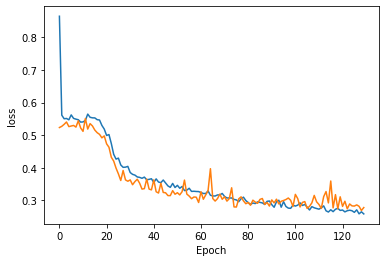

acc


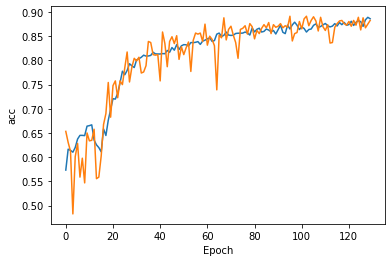

prec


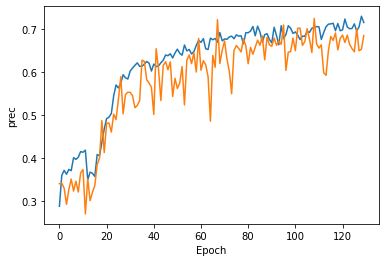

rec


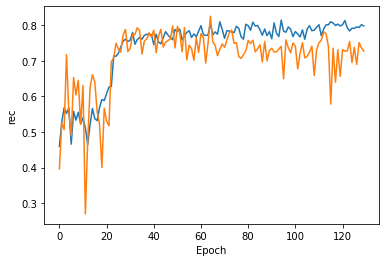

f1


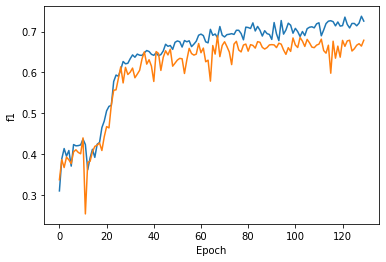

In [20]:
for metric in metrics["train"]:
    print(metric)
    for phase in metrics:
        plt.plot(range(len(metrics[phase][metric])), metrics[phase][metric])
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.show()

Visualize confusion matrix

In [ ]:
conf_mat = [[0, 0], [0, 0]]
for image, label in val_set:
    image = image.to(device)
    pred = model(image.unsqueeze()).squeeze()
    conf_mat[1 if pred.item() > 0.3 else 0][label.item()] += 1

In [ ]:
import seaborn as sns
sns.heatmap(conf_mat)